In [213]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
#from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding


In [93]:
train= pd.read_csv(r'C:\Users\vikil\Desktop\ML\data_Sets\twitter\train.csv')
test=pd.read_csv(r'C:\Users\vikil\Desktop\ML\data_Sets\twitter\test.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [7]:
train.isnull().sum().sort_values(ascending=False)

location    2533
keyword       61
target         0
text           0
id             0
dtype: int64

In [11]:
print('No. of real disaster tweets' , len(train[train['target']==1]))
print('No. of fake disaster tweets' ,len(train[train['target']==0]))

No. of real disaster tweets 3271
No. of fake disaster tweets 4342


In [12]:
train_real=len(train[train['target']==1])
train_fake=len(train[train['target']==0])

In [24]:
train.groupby('target')

In [27]:
real=[]
fake=[]
for i in range(0,len(train['text'])):
    if (train.iloc[i,4])==1:
        real.append(train['text'])
    else:
        fake.append(train['text'])

In [39]:
len(real)

3271

In [81]:
def draw_barplot(category,length,xlabel,ylabel,color):
    plt.bar(category,height=length,color='mykw')
    plt.legend()
    plt.xlabel=(xlabel)
    plt.ylabel=(ylabel)
    plt.title('Number of real and fake tweets')
    plt.show()    

No handles with labels found to put in legend.


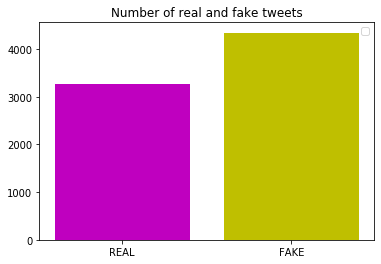

In [82]:
draw_barplot(['REAL','FAKE'],[train_real,train_fake],'Type of Tweet','Number of Tweets',color=['m','y'])

In [97]:
def length(text):    
    return len(text)

train["length"]= train.text.apply(length)

In [99]:
train['length'].mean()

101.03743596479706

In [102]:
train.groupby('target').mean()['length']

target
0     95.706817
1    108.113421
Name: length, dtype: float64

In [104]:
stop = list(stopwords.words("english"))

In [106]:
len(stop)

179

In [108]:
sw=[]
for sentence in train.text:
    for word in sentence.split():
        if word in stop:
            sw.append(word)

In [115]:
wordlist = nltk.FreqDist(sw)
len(wordlist)

148

In [116]:
top10 = wordlist.most_common(10)
len(top10)

10

In [117]:
print(top10)

[('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('for', 820), ('is', 814), ('on', 773), ('you', 632)]


In [120]:
punctuation = list(string.punctuation)

In [122]:
len(punctuation)

32

In [123]:
p=[]
for sentence in train.text:
    for pun in sentence:
        if pun in punctuation:
            p.append(pun)

In [127]:
punlist=nltk.FreqDist(p)

In [128]:
top_10_pun=punlist.most_common(10)

In [129]:
top_10_pun

[('/', 14585),
 ('.', 11696),
 (':', 6910),
 ('#', 3403),
 ("'", 3157),
 ('?', 3126),
 ('@', 2759),
 ('-', 1753),
 ('!', 1173),
 ('_', 863)]

In [152]:
sw_pun = stop + punctuation
lemma = WordNetLemmatizer()

In [158]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [160]:
train['text'] = train['text'].apply(lambda s : preprocess(s))
test['text'] = test['text'].apply(lambda s : preprocess(s))

In [161]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [162]:
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))


In [166]:
train.shape[1]

6

In [167]:
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

In [168]:
master=pd.concat((train,test)).reset_index(drop=True)

In [174]:
vocab = create_vocab(master)

In [175]:
len(vocab)

16439

In [176]:
vocabulary=nltk.FreqDist(vocab)

In [178]:
vocabulary.most_common(50)

[('like', 560),
 ('fire', 534),
 ('bomb', 338),
 ('news', 299),
 ('people', 286),
 ('burn', 262),
 ('time', 254),
 ('kill', 253),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 232),
 ('build', 231),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 220),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 199),
 ('look', 193),
 ('know', 192),
 ('love', 190),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 170),
 ('collapse', 169),
 ('wind', 165),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 149),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 147),
 ('year', 143),
 ('full', 143),
 ('service', 142)]

In [179]:
final_vocab = []
min_occur = 2
for x,y in vocab.items():
    if y >= min_occur:
        final_vocab.append(x)

In [180]:
len(final_vocab)

6024

In [186]:
sentence=""
word='fgh'
print(sentence + word + ' ')

fgh 


In [197]:
def cleaner(tweet):
    sentence = ""
    for word in tweet.split():
        if word in final_vocab:
            sentence=sentence + word+' '
    return sentence

In [199]:
train['text']=train['text'].apply(lambda s : cleaner(s))
test ['text'] = test ['text'].apply(lambda s : cleaner(s))

In [200]:
real = train[train.target==1].reset_index()
fake = train[train.target==0].reset_index()

In [204]:
def get_ngrams(data,n):
    all_words=[]
    for i in range(len(data)):
        temp = data["text"][i].split()
        for word in temp:
            all_words.append(word)
            
    tokenized = all_words
    esBigrams = ngrams(tokenized, n)
    
    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [205]:
real_unigrams = get_ngrams(real,1)
fake_unigrams = get_ngrams(fake,1)

In [206]:
real_unigrams

,0,1
0,"(fire,)",273
1,"(bomb,)",187
2,"(kill,)",161
3,"(news,)",145
4,"(flood,)",122
...,...,...
95,"(evacuation,)",40
96,"(saudi,)",39
97,"(rain,)",39
98,"(could,)",38


In [207]:
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

Using TensorFlow backend.
C:\Users\vikil\Anaconda3\ana\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vikil\Anaconda3\ana\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vikil\Anaconda3\ana\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vikil\Anaconda3\ana\lib\site-packages\tensorflow\python\fra

In [208]:
X = train.text
y = train.target

test_id = test.id
test.drop(["id","location","keyword"],1,inplace = True)

In [220]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [221]:
tokenizer = create_tokenizer(X_train)
X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')

In [211]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [222]:
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    # summarize defined model
    model.summary()
 #   plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [223]:
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               705920    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 706,049
Trainable params: 706,049
Non-trainable params: 0
_________________________________________________________________


In [225]:
#fit network
model.fit(X_train_set,y_train,epochs=10,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 27s - loss: 0.6302 - get_f1: 0.3357
Epoch 2/10
 - 12s - loss: 0.4432 - get_f1: 0.7678
Epoch 3/10
 - 12s - loss: 0.3447 - get_f1: 0.8260
Epoch 4/10
 - 12s - loss: 0.2878 - get_f1: 0.8551
Epoch 5/10
 - 14s - loss: 0.2475 - get_f1: 0.8830
Epoch 6/10
 - 12s - loss: 0.2167 - get_f1: 0.8965
Epoch 7/10
 - 12s - loss: 0.1917 - get_f1: 0.9076
Epoch 8/10
 - 12s - loss: 0.1721 - get_f1: 0.9223
Epoch 9/10
 - 12s - loss: 0.1547 - get_f1: 0.9291
Epoch 10/10
 - 11s - loss: 0.1401 - get_f1: 0.9381


In [227]:
# apply tokenizer on the test dataset
test_set = tokenizer.texts_to_matrix(test.text, mode = 'freq')

In [228]:
y_test_pred = model.predict_classes(test_set)

In [229]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.to_csv(r'C:\Users\vikil\Desktop\ML\data_Sets\twitter\submission_new.csv',index=False)